<a href="https://colab.research.google.com/github/tylerganter/deep-practice/blob/master/dlwp/dlwp_3_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with Python
## 3.6 Predicting House Prices: a regresion example

## Setup / Config

In [1]:
!pip uninstall tensorflow-gpu
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 450kB 55.6MB/s 
     |████████████████████████████████| 3.8MB 45.5MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goo

In [0]:
import json
import os
import psutil
import random
import time

from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.utils import to_categorical

In [2]:
assert tf.__version__.split(".")[0] == "2", "Unexpected version of tensorflow: {}".format(tf.__version__)
assert tf.test.is_gpu_available(), "No GPU found!"
print("Using tensorflow {}".format(tf.__version__))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Using tensorflow 2.1.0


In [3]:
def colab_time_left():
  start_time = time.time() - psutil.boot_time()
  time_left = 12 - start_time / 3600
  print('Time remaining for this colab session is: {:.2f} hrs'.format(time_left))
colab_time_left()

Time remaining for this colab session is: 11.94 hrs


## Load Data

In [0]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [19]:
print("Training samples: {}".format(train_data.shape))
print("Test samples:     {}".format(test_data.shape))
print("Training targets: {}".format(train_targets.shape))
print("Test target:      {}".format(test_targets.shape))

Training samples: (404, 13)
Test samples:     (102, 13)
Training targets: (404,)
Test target:      (102,)


## Normalize Data

In [0]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

## Define the model, train and evaluate using K-fold validation


In [0]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation="relu", input_shape=(13,)))
  model.add(layers.Dense(64, activation="relu"))
  model.add(layers.Dense(1))

  model.compile(
      optimizer="rmsprop",
      loss="mse",
      metrics=["mae"]
  )

  return model

In [41]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 200
all_mae_histories = []

for i in range(k):
  print('processing fold {}'.format(i))
  val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]

  partial_train_data = np.concatenate(
      (train_data[:i * num_val_samples],
       train_data[(i + 1) * num_val_samples:]),
      axis=0
  )
  partial_train_targets = np.concatenate(
      (train_targets[:i * num_val_samples],
       train_targets[(i + 1) * num_val_samples:]),
      axis=0
  )

  model = build_model()

  history = model.fit(
      partial_train_data, partial_train_targets,
      validation_data=(val_data, val_targets),
      epochs=num_epochs,
      batch_size=1,
      verbose=0
  )
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)
print('complete')

processing fold 0
complete
processing fold 1
complete
processing fold 2
complete
processing fold 3
complete


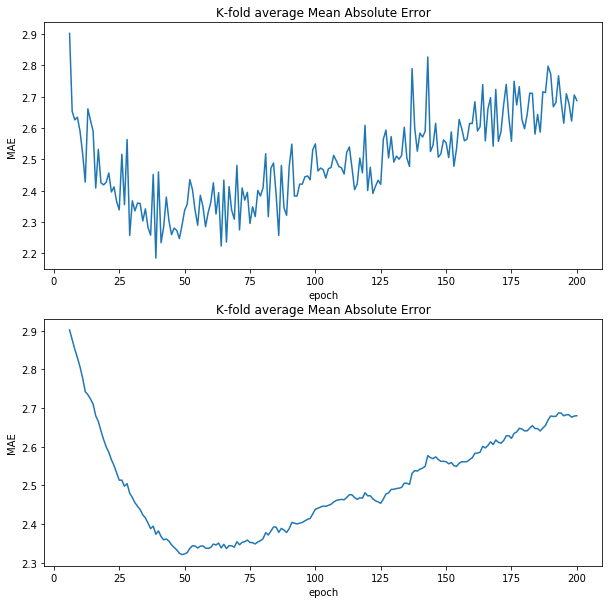

In [47]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      smoothed_points.append(
        point * (1 - factor)
        + smoothed_points[-1] * factor
      )
    else:
      smoothed_points.append(point)
  return smoothed_points

average_mae_history = [
  np.mean([x[i] for x in all_mae_histories])
  for i in range(num_epochs)
]

epochs = range(1, len(average_mae_history) + 1)

epochs = epochs[5:]
average_mae_history = average_mae_history[5:]

plt.figure(figsize=(10, 10))

plt.subplot(211)
plt.plot(epochs, average_mae_history)
plt.title("K-fold average Mean Absolute Error")
plt.xlabel("epoch")
plt.ylabel("MAE")

average_mae_history = smooth_curve(average_mae_history)

plt.subplot(212)
plt.plot(epochs, average_mae_history)
plt.title("K-fold average Mean Absolute Error")
plt.xlabel("epoch")
plt.ylabel("MAE");